# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [ ]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [ ]:
# YOUR CODE HERE
from common_utils import *

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

columns_to_drop = ['filename', 'label']
X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0)
X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test) # scaling is performed

loss_fn = nn.BCELoss() 

3. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [ ]:
def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    
    # YOUR CODE HERE
    X_train_scaled_dict = {}
    X_val_scaled_dict = {}
    y_train_dict = {}
    y_val_dict = {}
    
    no_folds = 5
    cv = KFold(n_splits=no_folds, shuffle=True, random_state=0)

    for batch_size in parameters:
        for fold_id, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
            
            X_train_scaled_list = []
            X_val_scaled_list = []
            y_train_list = []
            y_val_list = []
    
            x_train_fold, y_train_fold  = X_train[train_idx], y_train[train_idx]
            x_test_fold, y_test_fold = X_train[test_idx], y_train[test_idx]
        
            train_data = CustomDataset(x_train_fold, y_train_fold)
            test_data = CustomDataset(x_test_fold, y_test_fold)

            train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

            for _, (X, y) in enumerate(train_dataloader):
                X_train_scaled_list.append(X)
                y_train_list.append(y)
    
            for _, (X, y) in enumerate(test_dataloader):
                X_val_scaled_list.append(X)
                y_val_list.append(y)
            
            if fold_id == 0:
                X_train_scaled_dict[batch_size] = [X_train_scaled_list]
                X_val_scaled_dict[batch_size] = [X_val_scaled_list]
                y_train_dict[batch_size] = [y_train_list]
                y_val_dict[batch_size] = [y_val_list]
            else:
                X_train_scaled_dict[batch_size].append(X_train_scaled_list)
                X_val_scaled_dict[batch_size].append(X_val_scaled_list)
                y_train_dict[batch_size].append(y_train_list)
                y_val_dict[batch_size].append(y_val_list)

    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

batch_sizes = [128, 256, 512, 1024]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train_scaled, y_train)


4. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [ ]:
# YOUR CODE HERE
def train_loop(x_train, y_train, batch, model, loss_fn, optimizer):
    size = len(x_train)*batch
    num_batches = len(x_train)
    train_loss, train_correct = 0, 0
    train_start = time.time()
    for batch, (X, y) in enumerate(zip(x_train, y_train)):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred.flatten(), y.float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (len(pred) - torch.sum(torch.not_equal(pred.flatten() > 0.5, torch.tensor(y))))
    
    train_end = time.time()
    
    train_loss /= num_batches
    train_correct_accuracy = (train_correct.item()/size)
    # train_correct /=size
    time_taken = train_end - train_start
    return train_loss, train_correct_accuracy, time_taken

def test_loop(x_test, y_test, batch, model, loss_fn):
    size = len(x_test)*batch
    num_batches = len(x_test)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(zip(x_test, y_test)):
            pred = model(X)
            test_loss += loss_fn(pred.flatten(), y.float()).item()
            test_correct += (len(pred) - torch.sum(torch.not_equal(pred.flatten() > 0.5, torch.tensor(y))))

    test_loss /= num_batches
    test_correct_accuracy = (test_correct/size)
    
    #test_correct /= size
    return test_loss, test_correct_accuracy

In [63]:

# YOUR CODE HERE
batch_sizes = [128, 256, 512, 1024]

def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, param = 'batch_size'):
    no_epochs = 100
    no_folds = 5
    cross_validation_times = [] 
    cross_validation_accuracies = [] 
    for batch in batch_sizes:
        print(f"======== Batch size {batch} ========")
        train_time_taken_total = 0
        val_correct_total = 0
        for no_fold in range(no_folds):
            #early_stopper = EarlyStopper(patience=3, min_delta=0)
            no_inputs = X_train_scaled.shape[1]
            model = MLP(no_inputs, 128, 1)
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            
            for epoch in range(no_epochs):
                
                train_loss, train_correct, train_time_taken = train_loop(X_train_scaled_dict[batch][no_fold], y_train_dict[batch][no_fold], batch, model, loss_fn, optimizer)
       
                test_loss, test_correct = test_loop(X_val_scaled_dict[batch][no_fold], y_val_dict[batch][no_fold], batch, model, loss_fn)

                if epoch == no_epochs-1:
                    val_correct_total += test_correct
                    train_time_taken_total += train_time_taken
                    print(f"Fold {no_fold+1} : Epoch {epoch+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
                    print(f"Time taken on last epoch: {train_time_taken:>0.2f}s")
        
        print(f"Average cross_validation_times: {train_time_taken_total/no_folds:>.2f}s")      
        print(f"Average cross_validation_accuracies: {val_correct_total/no_folds*100:>.2f}%")  
                  
        cross_validation_times.append(train_time_taken_total / no_folds) 
        cross_validation_accuracies.append(val_correct_total / no_folds) 
        
    return cross_validation_accuracies, cross_validation_times



cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')

Fold 3 : Epoch 100: Train_accuracy: 85.83%, Train_loss: 0.211987, Test_accuracy: 59.72%, Test_loss: 0.709885
Time taken on last epoch: 0.08s
Fold 4 : Epoch 100: Train_accuracy: 85.51%, Train_loss: 0.209800, Test_accuracy: 58.94%, Test_loss: 0.788718
Time taken on last epoch: 0.13s
Fold 5 : Epoch 100: Train_accuracy: 85.99%, Train_loss: 0.207319, Test_accuracy: 59.77%, Test_loss: 0.741760
Time taken on last epoch: 0.09s
Average cross_validation_times: 0.09s
Average cross_validation_accuracies: 59.33%
======== Batch size 1024 ========
Fold 1 : Epoch 100: Train_accuracy: 85.06%, Train_loss: 0.231304, Test_accuracy: 58.45%, Test_loss: 0.748582
Time taken on last epoch: 0.07s
Fold 2 : Epoch 100: Train_accuracy: 84.58%, Train_loss: 0.240248, Test_accuracy: 59.42%, Test_loss: 0.696105
Time taken on last epoch: 0.05s
Fold 3 : Epoch 100: Train_accuracy: 84.39%, Train_loss: 0.240271, Test_accuracy: 58.64%, Test_loss: 0.739340
Time taken on last epoch: 0.06s
Fold 4 : Epoch 100: Train_accuracy: 84

5. Plot scatterplot of mean cross validation accuracies for the different batch sizes.

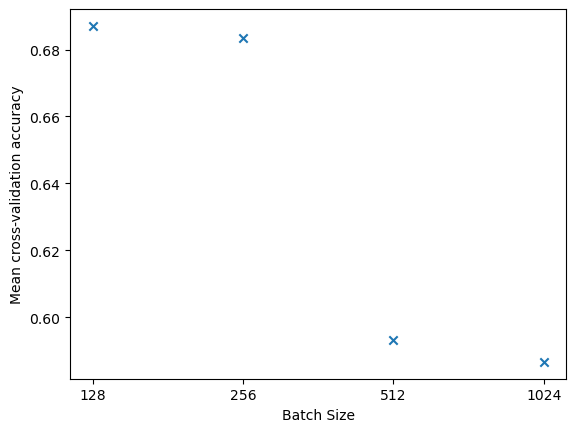

In [64]:
# YOUR CODE HERE
fig, ax = plt.subplots()
ax.scatter([str(bs) for bs in batch_sizes], cross_validation_accuracies, marker = 'x')
plt.xlabel('Batch Size')
plt.ylabel('Mean cross-validation accuracy')
plt.show()

6. Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [65]:
df = pd.DataFrame({'Batch Size': batch_sizes,
                   'Last Epoch Time': cross_validation_times
                  })

df

,Batch Size,Last Epoch Time
0,128,0.205486
1,256,0.142535
2,512,0.090009
3,1024,0.060376


In [70]:
# YOUR CODE HERE
optimal_batch_size = "256"
reason = "From the scatter plot, we can see that as batch size increases, cross validation accuracy decreases. \n\
    Upon increasing the batch size from 256 to 512, the cross validation accuracy dropped significantly. \n\
    This indicates the best batch size is between 128 and 256, as the cross validation accuracy of batch size 512 and 1024 is considerably lower compared to batch size 128 and 256. \n\
    Between 128 and 256, cross validation accuracy is comparable with each other, with batch size 128 only performing slightly better. \n\
    From the time taken to train as shown in the dataframe, using batch size 256 was faster than when batch size 128 was use. \n\
    The additional advantage of performing faster indicates batch size 256 is the optimal batch size. "

print("Optimal batch size:", optimal_batch_size)
print("Reason:", reason)

Optimal batch size: 256
Reason: From the scatter plot, we can see that as batch size increases, cross validation accuracy decreases. 
    Upon increasing the batch size from 256 to 512, the cross validation accuracy dropped significantly. 
    This indicates the best batch size is between 128 and 256, as the cross validation accuracy of batch size 512 and 1024 is considerably lower compared to batch size 128 and 256. 
    Between 128 and 256, cross validation accuracy is comparable with each other, with batch size 128 only performing slightly better. 
    From the time taken to train as shown in the dataframe, using batch size 256 was faster than when batch size 128 was use. 
    The additional advantage of performing faster indicates batch size 256 is the optimal batch size. 
